<div style="background-color:#192015; color:#7fa637; padding:12px; border-radius:8px; max-width:80%; width:auto; margin:0 auto;">

![nvmath-python](_assets/nvmath_head_panel@0.25x.png)

<p style="font-size:0.85em; margin-top:8px;">
Copyright (c) 2025, NVIDIA CORPORATION & AFFILIATES<br>
SPDX-License-Identifier: BSD-3-Clause
</p>

</div>

# Getting started with nvmath-python: FFT callbacks

In this tutorial we provide basic 101 about **nvmath-python**, how it fits in and plays with an existing scientific computing ecosystem in Python and what makes it a useful addition for this ecosystem. 
<div class="alert alert-box alert-info">
    To use this notebook you will need a computer equipped with NVIDIA GPU as well as an environment with properly installed Python libraries and (optionally) CUDA Toolkit. Please refer to the nvmath-python documentation for getting familiar with <a href="https://docs.nvidia.com/cuda/nvmath-python/0.2.1/installation.html#install-nvmath-python">installation options</a>.
</div>

This section focuses on FFT callbacks, which are custom Python functions *just-in-time* compiled into *intermediate representation* and provided as inputs to nvmath-python FFT as *prolog* or *epilog* arguments. 

But first, let's borrow the benchmarking helper function we created in the previous section to continue performance experiments with FFT implementations.

In [1]:
import numpy as np
import cupyx as cpx


# Helper function to benchmark two implementations F and (optionally) F_alternative
# When F_alternative is provided, in addition to raw performance numbers (seconds)
# speedup of F relative to F_alternative is reported
def benchmark(
    F, F_name="Implementation", F_alternative=None, F_alternative_name="Alternative implementation", n_repeat=10, n_warmup=1
):
    timing = cpx.profiler.benchmark(F, n_repeat=n_repeat, n_warmup=n_warmup)  # warm-up + repeated runs
    perf = np.min(timing.gpu_times)  # best time from repeated runs
    print(f"{F_name} performance = {perf:0.4f} sec")

    if F_alternative is not None:
        timing_alt = cpx.profiler.benchmark(F_alternative, n_repeat=n_repeat, n_warmup=n_warmup)
        perf_alt = np.min(timing_alt.gpu_times)
        print(f"{F_alternative_name} performance = {perf_alt:0.4f} sec")
        print(f"Speedup = {perf_alt / perf:0.4f}x")
    else:
        perf_alt = None

    return perf, perf_alt

In this notebook we touch upon a typical image processing problem known as the Gaussian filter. The following block implements the Gaussina filter using `scipy.ndimage` library.

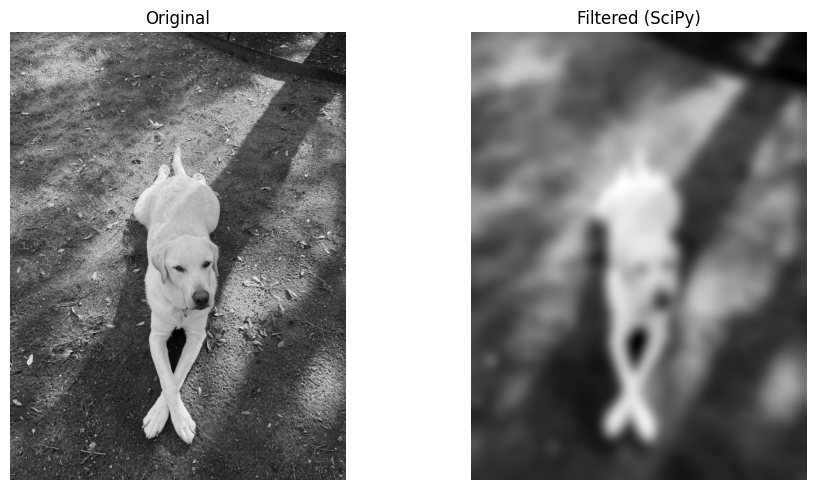

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter

asset_path = "./_assets/"
img = Image.open(asset_path + "dog.jpg").convert("L")
original_image = np.array(img, dtype=np.float32) / 255.0

sigma_value = 20.0  # Filter size

filtered_image_scipy = gaussian_filter(original_image, sigma=sigma_value)

# Plotting the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(filtered_image_scipy, cmap="gray")
plt.title("Filtered (SciPy)")
plt.axis("off")

plt.tight_layout()
plt.show()

Next, we will implement the Gaussian filter using CuPy's 2D forward and inverse FFT along with the filter (frequency response) applied in the frequency domain.

The frequency response is implemented in the `create_gaussian_kernel_2s()` function, which relies on the fact that the Fourier transform on a Gaussian distribution in the *spatial domain* corresponds to another Gaussian distribution in the *frequency domain* (and vice versa).

Please note that the original image is loaded as a numpy array in CPU memory space. To perform computation in GPU memory space, we explicitly convert the image to CuPy array, perform forward and inverse FFT transforms, and convert the final image back to CPU memory space for visualization with `matplotlib`.

/tmp/ipykernel_87683/1502827069.py:29: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()  # Clear CuPy FFT cache to ensure clean FFT benchmarking


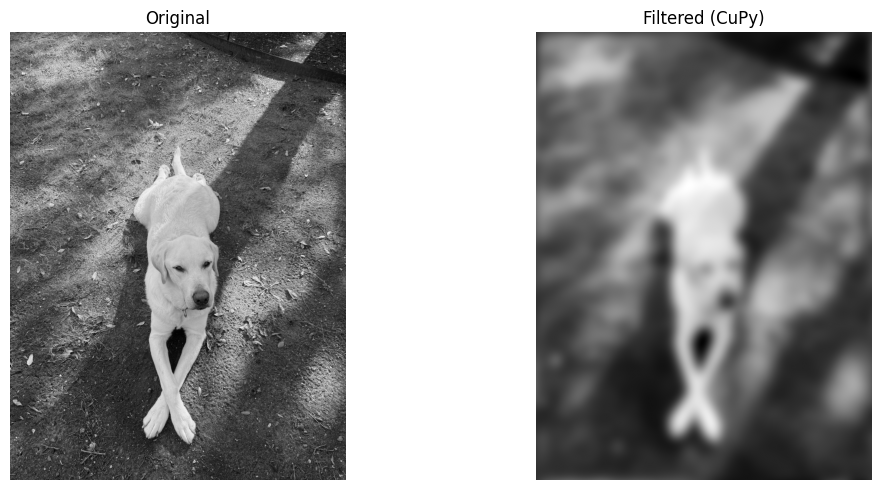

In [13]:
import nvmath  # Preload CTK libraries installed from wheels for CuPy
import cupy as cp


def create_gaussian_filter(shape, sigma):
    """
    Create the Gaussian filter's frequency response for R2C FFT.
    For R2C FFT, we only need the positive frequencies in the last dimension.
    """
    h, w = shape

    # frequency coordinates in cycles/sample for each axis (CuPy)
    fy = cp.fft.fftfreq(h)[:, None]  # column vector
    fx = cp.fft.rfftfreq(w)[None, :]  # row vector for R2C (only positive frequencies)

    # Continuous Fourier transform of a Gaussian
    # g(x)=exp(-x^2/(2*sigma^2)) is another Gaussian
    # G(f) = exp(-2 * pi^2 * sigma^2 * f^2). For 2D separable:
    # H(fx,fy) = exp(-2 * pi^2 * sigma^2 * (fx^2 + fy^2)).
    h_fx_fy = cp.exp(-2.0 * cp.pi * cp.pi * sigma * sigma * (fx * fx + fy * fy))
    return h_fx_fy.astype(cp.complex64)


def gaussian_filter_cupy(image, sigma, clear_cache=True):
    """
    Apply Gaussian filter using CuPy R2C/C2R FFT.
    """
    if clear_cache:
        cp.fft.config.clear_plan_cache()  # Clear CuPy FFT cache to ensure clean FFT benchmarking
    filter = create_gaussian_filter(image.shape, sigma)
    image_fft = cp.fft.rfft2(image)  # Real to complex FFT
    filtered = cp.fft.irfft2(image_fft * filter, s=image.shape)  # Complex to real FFT
    return filtered

image_gpu = cp.asarray(original_image, dtype=cp.float32)
filtered_image_cupy = gaussian_filter_cupy(image_gpu, sigma_value)

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cp.asnumpy(filtered_image_cupy), cmap="gray")
plt.title("Filtered (CuPy)")
plt.axis("off")

plt.tight_layout()
plt.show()

We implement the Gaussian filter using nvmath-python forward and inverse FFTs. Note that `create_gaussian_kernel_2d` is now part of the `epilog_impl` function compiled to the intermediate representation (LTO-IR) and supplied to the forward FFT as an *epilog*. This allows fusing the epilog with FFT, which improves the *arithmetic intensity* of the composite operation. However, you will pay a one-time cost related to the JIT compilation overhead.

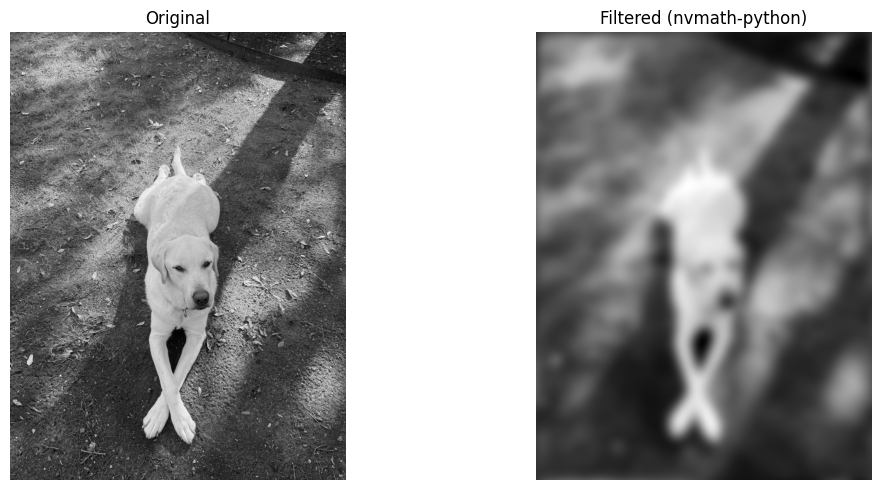

In [14]:
def gaussian_filter_nvmath(image, sigma):
    """
    Apply Gaussian filter using nvmath FFT helper functions on GPU with epilog.

    This function uses nvmath.fft.rfft / nvmath.fft.irfft with an epilog to perform
    the gaussian kernel multiplication directly within the FFT operation.
    The input is moved to GPU as a CuPy real array and results are returned as NumPy array.
    """
    wh = image.shape[0] * image.shape[1]

    # Gaussian kernel on GPU for R2C FFT
    filter = create_gaussian_filter(image.shape, sigma)

    # Define epilog function for gaussian kernel multiplication
    def epilog_impl(data_out, offset, data, filter_data, unused):
        """Epilog function to multiply FFT data with gaussian kernel."""
        data_out[offset] = data * filter_data[offset] / wh  # Normalize by the image area

    # Compile the epilog to LTO-IR
    epilog = nvmath.fft.compile_epilog(epilog_impl, "complex64", "complex64")

    # Compute R2C FFT using nvmath with epilog to apply gaussian kernel multiplication
    image_fft = nvmath.fft.rfft(image, epilog={"ltoir": epilog, "data": filter.data.ptr})

    # Inverse C2R FFT using nvmath
    filtered = nvmath.fft.irfft(image_fft)

    return filtered


image_gpu = cp.asarray(original_image, dtype=cp.float32)
filtered_image_nvmath = gaussian_filter_nvmath(image_gpu, sigma_value)

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cp.asnumpy(filtered_image_nvmath), cmap="gray")
plt.title("Filtered (nvmath-python)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [5]:
benchmark(
    lambda: gaussian_filter_nvmath(image_gpu, sigma_value),
    "nvmath-python API",
    lambda: gaussian_filter_cupy(image_gpu, sigma_value),
    "CuPy API",
)

nvmath-python API performance = 0.2673 sec


/tmp/ipykernel_87683/4100599085.py:29: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()  # Clear CuPy FFT cache to ensure clean FFT benchmarking


CuPy API performance = 0.2375 sec
Speedup = 0.8885x


(np.float64(0.26731497192382814), np.float64(0.2375004119873047))

The nvmath-python provides both *stateless* and *stateful* APIs for FFT so that you can separate the *planning* (including expensive JIT compilation of the epilog) and *exefution* phases and amortize the *planning* cost through multiple executions.

To illustrate this let us consider the problem of applying the Gaussian filter to multiple images in a batch:

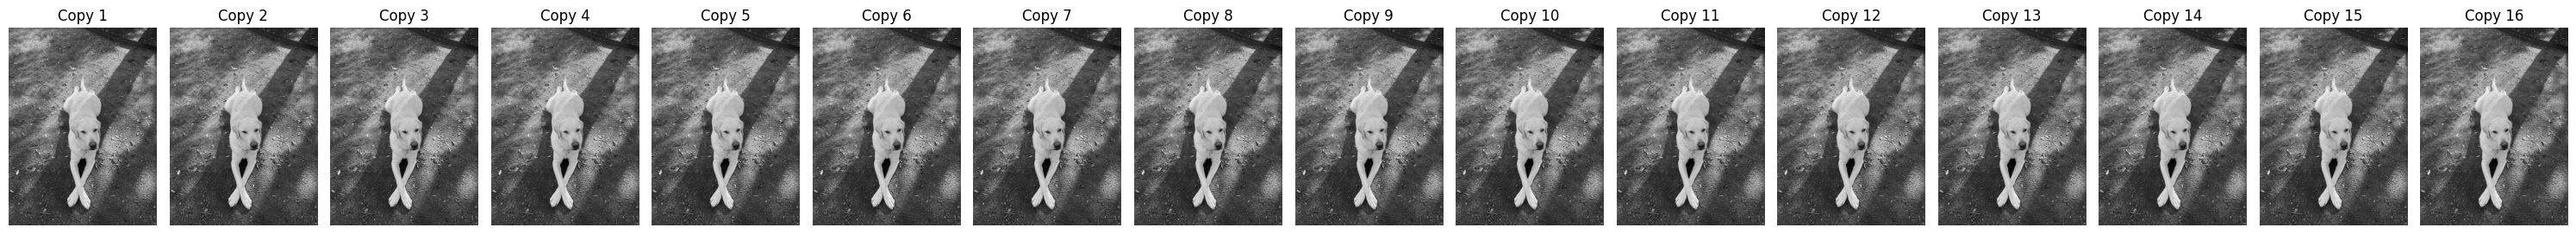

In [6]:
batch_size = 16
images_gpu = [image_gpu] * batch_size

# Display the array of identical images
plt.figure(figsize=(30, 3))

for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(cp.asnumpy(images_gpu[i]), cmap="gray")
    plt.title(f"Copy {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

First, we create a reference implementation of the batched Gaussian filter using pure CuPy.

/tmp/ipykernel_87683/467117906.py:7: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


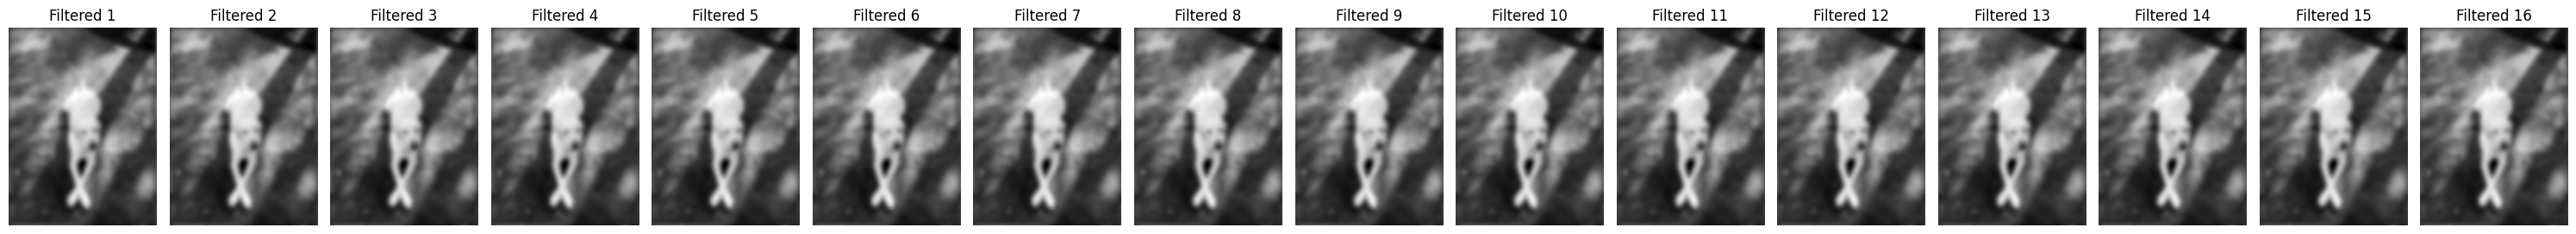

In [7]:
def process_batch_cupy(images_gpu, sigma_value):
    """
    Process a batch of images using CuPy.
    """
    # Clear CuPy FFT cache to ensure clean FFT benchmarking during multiple repetitions (n_repeat > 1)
    # For fair comparison, we do not want the planning cost of the first call to be ignored
    cp.fft.config.clear_plan_cache()
    filtered_images = []
    for i in range(len(images_gpu)):
        filtered_images.append(gaussian_filter_cupy(images_gpu[i], sigma_value, clear_cache=False))
    return filtered_images


filtered_images = process_batch_cupy(images_gpu, sigma_value)

plt.figure(figsize=(30, 3))

for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(cp.asnumpy(filtered_images[i]), cmap="gray")
    plt.title(f"Filtered {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Next, we implement the same logic using nvmath-python's stateful API. We create two FFT objects, one for the forward FFT plan, which includes a compiled epilog, and another is for the inverse FFT plan. It is essential to create two objects because a single object can only have one plan. Finally we apply the filter to each image in the batch through a series of forward and inverse FFTs. Please also note that `reset_operand()` method must be properly used to update operands for a chained FFT operations. 

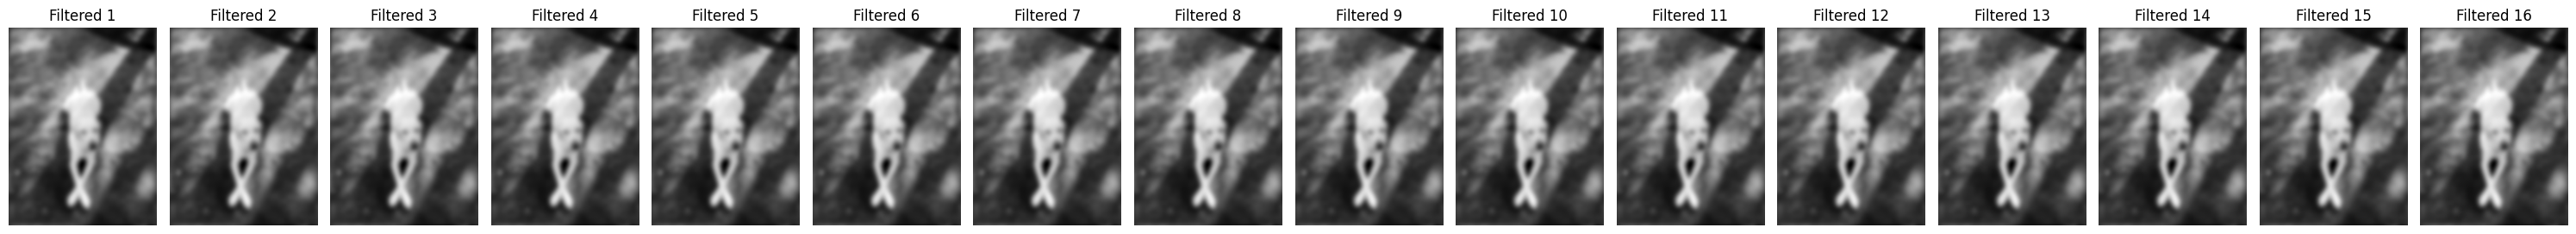

In [8]:
def process_batch_nvmath(images_gpu, sigma):
    """
    Process a batch of images using nvmath with stateful API.

    This function uses the stateful API to create a persistent FFT plan
    and epilog that can be reused across multiple images in the batch.
    """

    # Create the gaussian kernel once for the batch (R2C format)
    filter = create_gaussian_filter(images_gpu[0].shape, sigma).astype(cp.complex64)
    wh = images_gpu[0].shape[0] * images_gpu[0].shape[1]


    # Define epilog function for gaussian kernel multiplication
    def epilog_impl(data_out, offset, data, filter_data, unused):
        """Epilog implementation."""
        data_out[offset] = data * filter_data[offset] / wh  # Normalize by the image area


    # Compile the epilog to LTO-IR once
    epilog = nvmath.fft.compile_epilog(epilog_impl, "complex64", "complex64")


    def convolve_gpu(fft, ifft, image_gpu):
        fft.reset_operand(image_gpu)
        image_fft = fft.execute(direction=nvmath.fft.FFTDirection.FORWARD)
        ifft.reset_operand(image_fft)
        image_ifft = ifft.execute(direction=nvmath.fft.FFTDirection.INVERSE)
        return image_ifft


    image_gpu = images_gpu[0]  # Real input for R2C FFT
    image_fft = cp.empty((image_gpu.shape[0], image_gpu.shape[1] // 2 + 1), dtype=cp.complex64)

    with (
        nvmath.fft.FFT(image_gpu) as fft,
        nvmath.fft.FFT(image_fft, options={"fft_type": "C2R"}) as ifft,
    ):
        # Two plans are created, one for the forward R2C FFT with an epilog
        # and another for the inverse C2R FFT
        fft.plan(epilog={"ltoir": epilog, "data": filter.data.ptr})
        ifft.plan()

        # Process each image in the batch
        filtered_images = []
        for i in range(len(images_gpu)):
            filtered_images.append(convolve_gpu(fft, ifft, images_gpu[i]))
    return filtered_images


# Process the batch using nvmath stateful API
filtered_images_nvmath = process_batch_nvmath(images_gpu, sigma_value)

plt.figure(figsize=(30, 3))

for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(cp.asnumpy(filtered_images_nvmath[i]), cmap="gray")
    plt.title(f"Filtered {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Finally, let us take a look at the performance. Please remember, CuPy inherently performs FFT plans *caching* so that a subsequent calls with images of the same shape and dtype will avoid re-planning overhead. With nvmath-python we avoid re-planning explicitly by using *stateful* APIs.

In [9]:
# Clear CuPy FFT cache to ensure clean FFT operations
cp.fft.config.clear_plan_cache()
benchmark(
    lambda: process_batch_nvmath(images_gpu, sigma_value),
    "nvmath-python stateful API",
    lambda: process_batch_cupy(images_gpu, sigma_value),
    "CuPy API",
)

/tmp/ipykernel_87683/2916130351.py:2: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


nvmath-python stateful API performance = 0.3109 sec


/tmp/ipykernel_87683/467117906.py:7: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


CuPy API performance = 0.2374 sec
Speedup = 0.7634x


(np.float64(0.3109353332519531), np.float64(0.2373632049560547))

Let us drill down how much each phase costs in each of the libraries. For CuPy the cost of the very first call, where FFT planning and plan caching is performed, will be very different from the subsequent calls, where the cached plan is reused.

In [10]:
def process_cupy_first_call(image_gpu, sigma_value):
    # To emulate the cost of the first call we need to clear the cache
    cp.fft.config.clear_plan_cache()
    gaussian_filter_cupy(image_gpu, sigma_value, clear_cache=False)

def process_cupy_subsequent_call(image_gpu, sigma_value):
    # With n_repeat > 1 the first call cost will be ignored
    gaussian_filter_cupy(image_gpu, sigma_value, clear_cache=False)

perf_cupy_subsequent_call, perf_cupy_first_call = benchmark(
    lambda: process_cupy_subsequent_call(image_gpu, sigma_value),
    "CuPy subsequent calls",
    lambda: process_cupy_first_call(image_gpu, sigma_value),
    "CuPy first call",
)

perf_cupy_planning = perf_cupy_first_call - perf_cupy_subsequent_call
print(f"Estimated CuPy planning cost = {perf_cupy_planning:0.4f} sec")


CuPy subsequent calls performance = 0.0043 sec


/tmp/ipykernel_87683/2141742462.py:3: FutureWarning: cupy.fft.cache.clear_plan_cache is experimental. The interface can change in the future.
  cp.fft.config.clear_plan_cache()


CuPy first call performance = 0.1394 sec
Speedup = 32.6704x
Estimated CuPy planning cost = 0.1351 sec


Similarly, let's atomize the costs within nvmath-python implementation:

In [11]:
# Create the gaussian kernel once for the batch (R2C format)
filter = create_gaussian_filter(image_gpu.shape, sigma_value).astype(cp.complex64)
wh = image_gpu.shape[0] * image_gpu.shape[1]

# Define epilog function for gaussian kernel multiplication
def epilog_impl(data_out, offset, data, filter_data, unused):
    """Epilog implementation."""
    data_out[offset] = data * filter_data[offset] / wh  # Normalize by the image area

# Compile the epilog to LTO-IR once
def compile_epilog():
    return nvmath.fft.compile_epilog(epilog_impl, "complex64", "complex64")

def forward_fft_execute(fft, image_gpu):
    fft.reset_operand(image_gpu)
    return fft.execute(direction=nvmath.fft.FFTDirection.FORWARD)

def inverse_fft_execute(ifft, image_gpu):
    ifft.reset_operand(image_gpu)
    return ifft.execute(direction=nvmath.fft.FFTDirection.INVERSE)

def forward_fft_plan(image_gpu, epilog):
    fft = nvmath.fft.FFT(image_gpu)
    fft.plan(epilog={"ltoir": epilog, "data": filter.data.ptr})
    return fft

def inverse_fft_plan(c2r_output):
    ifft = nvmath.fft.FFT(c2r_output, options={"fft_type": "C2R"})
    ifft.plan()
    return ifft

epilog = compile_epilog()
c2r_output = cp.empty((image_gpu.shape[0], image_gpu.shape[1] // 2 + 1), dtype=cp.complex64)
fft = forward_fft_plan(image_gpu, epilog)
ifft = inverse_fft_plan(c2r_output)
fft_image = forward_fft_execute(fft, image_gpu)
filtered_image = inverse_fft_execute(ifft, fft_image)

print(image_gpu.sum())
print(filtered_image.sum())

perf_compile_epilog = cpx.profiler.benchmark(lambda: compile_epilog(), n_repeat=5, n_warmup=1).gpu_times.min()
perf_forward_fft_plan = cpx.profiler.benchmark(lambda: forward_fft_plan(image_gpu, epilog), n_repeat=5, n_warmup=1).gpu_times.min()
perf_inverse_fft_plan = cpx.profiler.benchmark(lambda: inverse_fft_plan(c2r_output), n_repeat=5, n_warmup=1).gpu_times.min()
perf_forward_fft_execute = cpx.profiler.benchmark(lambda: forward_fft_execute(fft, image_gpu), n_repeat=5, n_warmup=1).gpu_times.min()
perf_inverse_fft_execute = cpx.profiler.benchmark(lambda: inverse_fft_execute(ifft, fft_image), n_repeat=5, n_warmup=1).gpu_times.min()

print(f"Compilation cost = {perf_compile_epilog:0.4f} sec")
print(f"Forward FFT plan cost = {perf_forward_fft_plan:0.4f} sec")
print(f"Inverse FFT plan cost = {perf_inverse_fft_plan:0.4f} sec")
print(f"Forward FFT execute cost = {perf_forward_fft_execute:0.4f} sec")
print(f"Inverse FFT execute cost = {perf_inverse_fft_execute:0.4f} sec")


766663.06
766663.0
Compilation cost = 0.0141 sec
Forward FFT plan cost = 0.2388 sec
Inverse FFT plan cost = 0.0026 sec
Forward FFT execute cost = 0.0130 sec
Inverse FFT execute cost = 0.0046 sec


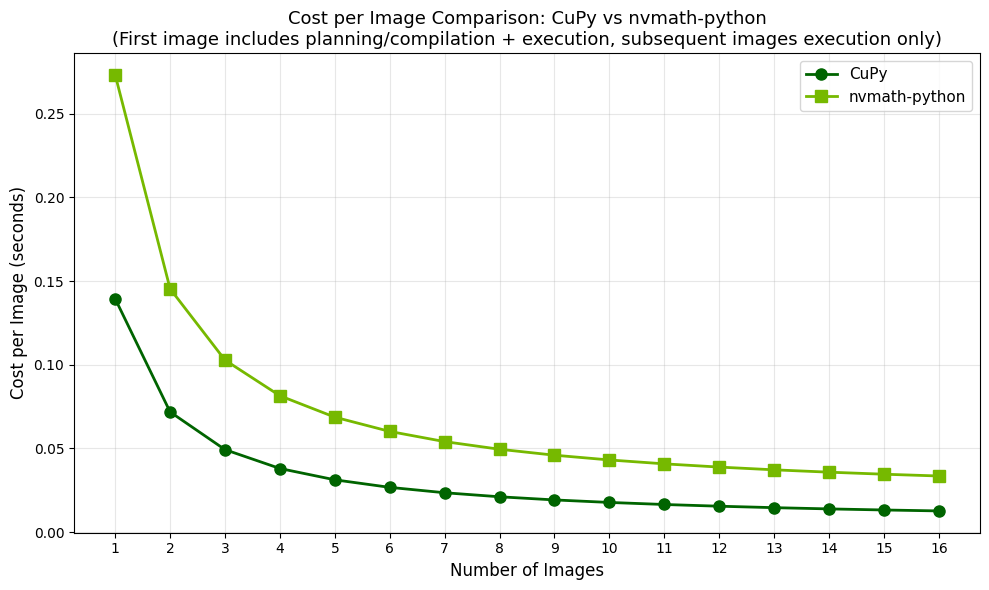

CuPy Cost Breakdown:
  Planning cost: 0.1351 sec
  Execution cost (per image): 0.0043 sec
  First image total: 0.1394 sec

nvmath-python Cost Breakdown:
  Compilation cost: 0.0141 sec
  Forward FFT plan cost: 0.2388 sec
  Inverse FFT plan cost: 0.0026 sec
  Execution cost (per image): 0.0176 sec
  First image total: 0.2731 sec

Cost per image comparison:
   1 images: CuPy=0.1394 sec/img, nvmath=0.2731 sec/img, speedup=0.51x
   4 images: CuPy=0.0380 sec/img, nvmath=0.0815 sec/img, speedup=0.47x
   8 images: CuPy=0.0212 sec/img, nvmath=0.0495 sec/img, speedup=0.43x
  16 images: CuPy=0.0127 sec/img, nvmath=0.0336 sec/img, speedup=0.38x


In [12]:
# Plot CuPy and nvmath-python cost per image for batch sizes 1 to 16
batch_sizes = np.arange(1, 17)

# CuPy: First image includes planning + execution, subsequent images are execution only
cupy_costs_per_image = [(perf_cupy_first_call + (n - 1) * perf_cupy_subsequent_call) / n for n in batch_sizes]

# nvmath-python: First image includes compilation + planning + execution, subsequent images are execution only
nvmath_costs_per_image = [(perf_compile_epilog + perf_forward_fft_plan + perf_inverse_fft_plan) / n + perf_forward_fft_execute + perf_inverse_fft_execute for n in batch_sizes]

plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, cupy_costs_per_image, marker='o', linewidth=2, markersize=8, color='darkgreen', label='CuPy')
plt.plot(batch_sizes, nvmath_costs_per_image, marker='s', linewidth=2, markersize=8, color='#76b900', label='nvmath-python')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Cost per Image (seconds)', fontsize=12)
plt.title('Cost per Image Comparison: CuPy vs nvmath-python\n(First image includes planning/compilation + execution, subsequent images execution only)', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(batch_sizes)
plt.tight_layout()
plt.show()

# Print some statistics
print("CuPy Cost Breakdown:")
print(f"  Planning cost: {perf_cupy_planning:.4f} sec")
print(f"  Execution cost (per image): {perf_cupy_subsequent_call:.4f} sec")
print(f"  First image total: {perf_cupy_first_call:.4f} sec")

print("\nnvmath-python Cost Breakdown:")
print(f"  Compilation cost: {perf_compile_epilog:.4f} sec")
print(f"  Forward FFT plan cost: {perf_forward_fft_plan:.4f} sec")
print(f"  Inverse FFT plan cost: {perf_inverse_fft_plan:.4f} sec")
print(f"  Execution cost (per image): {perf_forward_fft_execute + perf_inverse_fft_execute:.4f} sec")
print(f"  First image total: {perf_compile_epilog + perf_forward_fft_plan + perf_inverse_fft_plan + perf_forward_fft_execute + perf_inverse_fft_execute:.4f} sec")

print("\nCost per image comparison:")
for n in [1, 4, 8, 16]:
    cupy_per_img = cupy_costs_per_image[n-1]
    nvmath_per_img = nvmath_costs_per_image[n-1]
    speedup = cupy_per_img / nvmath_per_img
    print(f"  {n:2d} images: CuPy={cupy_per_img:.4f} sec/img, nvmath={nvmath_per_img:.4f} sec/img, speedup={speedup:.2f}x")


<div style="background-color:#76B900; color:#ffffff; padding:12px; border-radius:8px; max-width:80%; width:auto; margin:0 auto;">
<h3 style="margin-top:0; color:#ffffff">Takeaways</h3>

- FFT callbacks allow custom Python functions to be JIT-compiled and fused with FFT kernels as prolog or epilog operations.
- JIT compilation overhead is a one-time cost that can be amortized across multiple executions.
- CuPy has a built-in plan caching mechanism allowing to amortize initial planning cost across executions.
- nvmath-python stateful API amortize compilation and planning costs as well as avoid plan cache retrival cost in subsequent executions.
</div>